<a href="https://www.kaggle.com/code/dilekdd/rfm-analysis-ii?scriptVersionId=195502427" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

#  **Customer Segmentation with RFM**

An e-commerce company wants to divide its customers into segments and determine marketing strategies based on these segments.

The dataset named Online Retail II includes sales of a UK based online retailer between 01/12/2009 - 09/12/2011.

Variables
InvoiceNo: Invoice number. Unique number for each transaction, i.e. invoice. Canceled transaction if it starts with C.
StockCode: Product code. Unique number for each product.
Description: Product name
Quantity: Number of products. Indicates how many of the products on the invoices were sold.
InvoiceDate: Invoice date and time.
UnitPrice: Product price (in pounds)
CustomerID: Unique customer number
Country: Country name. Country where the customer lives.

In [1]:
import datetime as dt
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import squarify
pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
sns.set_style('whitegrid')

In [2]:
df_ = pd.read_excel("/kaggle/input/online-retail-ii/online_retail_II.xlsx", sheet_name="Year 2010-2011")

In [3]:
df = df_.copy()

In [4]:
def quick_overview(df_summary):
    print(f"Shape Details\n{df_summary.shape}\n")
    print(f"First 5 observations\n{df_summary.head()}\n")
    print(f"Missing values by variables\n{df_summary.isnull().sum()}\n")
    print(f"Descriptive statistics for numerical variables\n{df_summary.describe()}\n")
    print(f"Overview of the DataFrame :")
    df_summary.info()
    

quick_overview(df)

Shape Details
(541910, 8)

First 5 observations
  Invoice StockCode                          Description  Quantity  \
0  536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1  536365     71053                  WHITE METAL LANTERN         6   
2  536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3  536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4  536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  Price  Customer ID         Country  
0 2010-12-01 08:26:00  2.550    17850.000  United Kingdom  
1 2010-12-01 08:26:00  3.390    17850.000  United Kingdom  
2 2010-12-01 08:26:00  2.750    17850.000  United Kingdom  
3 2010-12-01 08:26:00  3.390    17850.000  United Kingdom  
4 2010-12-01 08:26:00  3.390    17850.000  United Kingdom  

Missing values by variables
Invoice             0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
Price               0
Customer I

**Data Preparation**

In [5]:
df["TotalPrice"] = df["Quantity"] * df["Price"]
df.dropna(inplace=True)
df["Invoice"] = df["Invoice"].astype(str)
df = df[~df["Invoice"].str.contains("C", na=False)]
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.550,17850.000,United Kingdom,15.300
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.390,17850.000,United Kingdom,20.340
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.750,17850.000,United Kingdom,22.000
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.390,17850.000,United Kingdom,20.340
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.390,17850.000,United Kingdom,20.340


**Calculating RFM Metrics**

In [6]:
today_date = dt.datetime(2011, 12, 11)
rfm = df.groupby('Customer ID').agg({'InvoiceDate': lambda date: (today_date - date.max()).days,
                                            'Invoice': lambda num: num.nunique(),
                                            "TotalPrice": lambda price: price.sum()})
rfm.columns = ['recency', 'frequency', "monetary"]
rfm = rfm[(rfm['monetary'] > 0)]
rfm.head()

,recency,frequency,monetary
Customer ID,,,
12346.000,326,1,77183.600
12347.000,3,7,4310.000
12348.000,76,4,1797.240
12349.000,19,1,1757.550
12350.000,311,1,334.400


**Calculating RFM Scores**

In [7]:
rfm["recency_score"] = pd.qcut(rfm['recency'], 5, labels=[5, 4, 3, 2, 1])
rfm["frequency_score"] = pd.qcut(rfm["frequency"].rank(method="first"), 5, labels=[1, 2, 3, 4, 5])
rfm["monetary_score"] = pd.qcut(rfm['monetary'], 5, labels=[1, 2, 3, 4, 5])

rfm["RFM_SCORE"] = (rfm['recency_score'].astype(str) +
                    rfm['frequency_score'].astype(str))

rfm.head()

,recency,frequency,monetary,recency_score,frequency_score,monetary_score,RFM_SCORE
Customer ID,,,,,,,
12346.000,326,1,77183.600,1,1,5,11
12347.000,3,7,4310.000,5,5,5,55
12348.000,76,4,1797.240,2,4,4,24
12349.000,19,1,1757.550,4,1,4,41
12350.000,311,1,334.400,1,1,2,11


**Segmentation**

In [8]:
seg_map = {r'[1-2][1-2]': 'hibernating',
           r'[1-2][3-4]': 'at_Risk',
           r'[1-2]5': 'cant_loose',
           r'3[1-2]': 'about_to_sleep',
           r'33': 'need_attention',
           r'[3-4][4-5]': 'loyal_customers',
           r'41': 'promising',
           r'51': 'new_customers',
           r'[4-5][2-3]': 'potential_loyalists',
           r'5[4-5]': 'champions'}

rfm['segment'] = rfm['RFM_SCORE'].replace(seg_map, regex=True)
rfm = rfm[["recency", "frequency", "monetary", "segment"]]
rfm.index = rfm.index.astype(int)

rfm.head()

,recency,frequency,monetary,segment
Customer ID,,,,
12346,326,1,77183.600,hibernating
12347,3,7,4310.000,champions
12348,76,4,1797.240,at_Risk
12349,19,1,1757.550,promising
12350,311,1,334.400,hibernating


**Customer Segmentation Map**

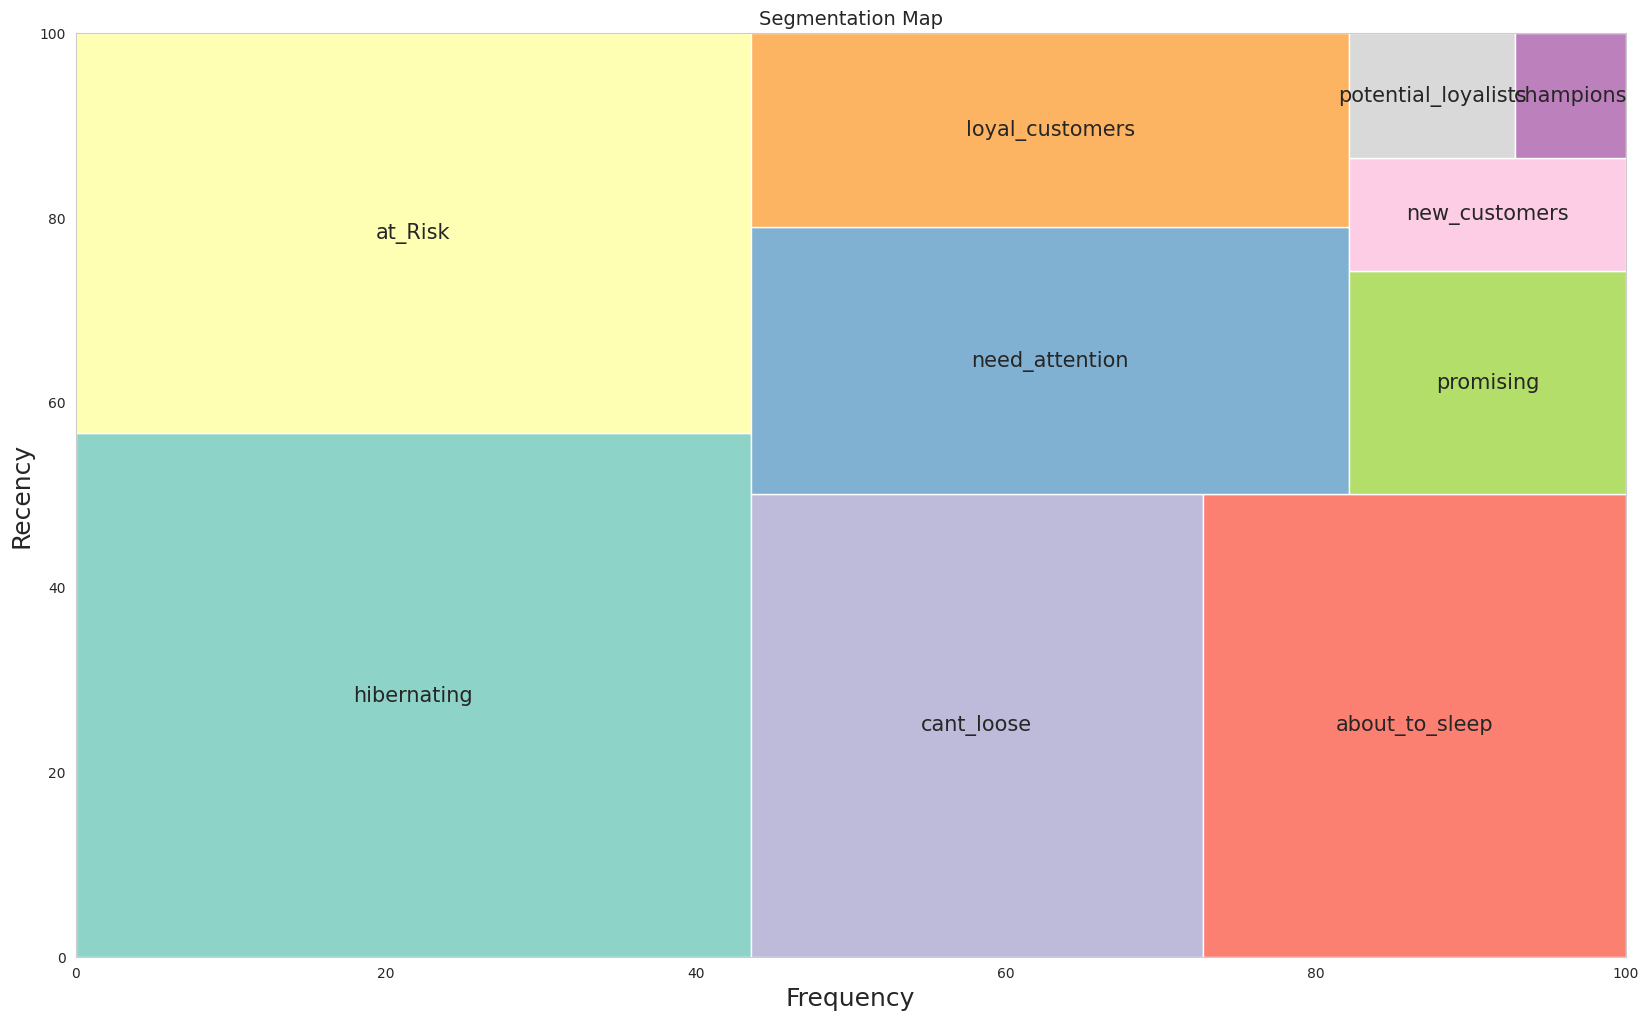

In [9]:
segments = rfm["segment"].value_counts().sort_values(ascending=False)
fig = plt.gcf()
ax = fig.add_subplot()
fig.set_size_inches(20, 12)

palette = sns.color_palette("Set3", len(segments)) 

squarify.plot(
    sizes=segments,
    label=[label for label in seg_map.values()],
    color=palette, 
    pad=False,
    bar_kwargs={"alpha": 1},
    text_kwargs={"fontsize": 15},
)

plt.title("Segmentation Map", fontsize=14)
plt.xlabel("Frequency", fontsize=18)
plt.ylabel("Recency", fontsize=18)
plt.show()